Usage example of MediaPipe Pose Solution API in Python (see also http://solutions.mediapipe.dev/pose).

In [1]:
#!pip install mediapipe

In [1]:
!nvidia-smi

Mon Nov 15 11:00:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   37C    P8    19W / 250W |    250MiB / 11011MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel

from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets import human36m_SMPL
from mvn.datasets import human36m_custom
from mvn.datasets import human36m_EXTENDED
import copy
from mvn.utils.img import get_square_bbox, resize_image, crop_image, normalize_image, scale_bbox
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [3]:
def process_view(batch, view_i, model):
    current_image = batch['images'][0,view_i, :,:,:]
    current_original_image = copy.deepcopy(batch['original_image'][0,view_i, :,:,:])
    current_detections = batch['detections'][0,view_i, :]
    #print(iter_i)
    croped_original = crop_image(current_original_image, current_detections[:4])
    
    #croped_resized_original = cv2.resize(croped_original, (480, 720))
    #croped_resized_original.shape

    #image = croped_resized_original
    
    image = croped_original
    
    #image = current_original_image
    results = model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Print nose landmark.
    image_hight, image_width, _ = image.shape

    if results.pose_landmarks:
        # Draw pose landmarks.
        #annotated_image = image.copy()
        annotated_image = image
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec)
        #plt.imshow(annotated_image[:,:,::-1])

        #result_image_list.append(annotated_image)
        return annotated_image, results
        
    else:
        #result_image_list.append(image)
        return image, results

In [4]:
'''
subject_name = 'S11'
action_name = 'TakingPhoto-1'


# HUMAN36M_dataset = human36m_SMPL.Human36MMultiViewDataset_SMPL(h36m_root='/datasets/human3.6m_LT_custom/processed/',
#                  labels_path='/datasets/human3.6m_LT_custom/extra/human36m-multiview-labels-GTbboxes.npy',
#                  pred_results_path=None,
#                  image_shape=(384, 384),
#                  train=False,
#                  test=True,
#                  retain_every_n_frames_in_test=1,
#                  with_damaged_actions=False,
#                  cuboid_side=2000.0,
#                  scale_bbox=1.5,
#                  norm_image=True,
#                  kind="mpii",
#                  undistort_images=False,
#                  ignore_cameras=[],
#                  crop=True,
#                  target_subject = subject_name,
#                  target_action = action_name)



HUMAN36M_dataset = human36m_SMPL.Human36MMultiViewDataset_SMPL(
            h36m_root="/datasets/human3.6m_LT/processed/",
            pred_results_path="./logs_wholebody/eval_human36m_alg_DONOTSHUFFLE_SMPL_AlgebraicTriangulationNet_TEST/checkpoints/0000/results.pkl",
            train=False,
            test=True,
            image_shape= (384, 288),
            labels_path="/datasets/human3.6m_LT/extra/human36m-multiview-labels-GTbboxes_SMPL_0802.npy",
            with_damaged_actions=True,
            scale_bbox=1.2,
            kind="human36m",
            undistort_images=True,
            ignore_cameras= [],
            crop= True,
            option_384x288=True,
        )



HUMAN36M_dataloader = DataLoader(
    HUMAN36M_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=dataset_utils.make_collate_fn(False,
                                             min_n_views=4,
                                             max_n_views=4),
    num_workers=8,
    worker_init_fn=dataset_utils.worker_init_fn,
    pin_memory=True
)
print(HUMAN36M_dataset.__len__())
'''

'\nsubject_name = \'S11\'\naction_name = \'TakingPhoto-1\'\n\n\n# HUMAN36M_dataset = human36m_SMPL.Human36MMultiViewDataset_SMPL(h36m_root=\'/datasets/human3.6m_LT_custom/processed/\',\n#                  labels_path=\'/datasets/human3.6m_LT_custom/extra/human36m-multiview-labels-GTbboxes.npy\',\n#                  pred_results_path=None,\n#                  image_shape=(384, 384),\n#                  train=False,\n#                  test=True,\n#                  retain_every_n_frames_in_test=1,\n#                  with_damaged_actions=False,\n#                  cuboid_side=2000.0,\n#                  scale_bbox=1.5,\n#                  norm_image=True,\n#                  kind="mpii",\n#                  undistort_images=False,\n#                  ignore_cameras=[],\n#                  crop=True,\n#                  target_subject = subject_name,\n#                  target_action = action_name)\n\n\n\nHUMAN36M_dataset = human36m_SMPL.Human36MMultiViewDataset_SMPL(\n            h36m_r

In [5]:
import os
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy

import numpy as np
import cv2

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel

from mvn.models.triangulation_wholebody import VolumetricTriangulationNet_Wholebody
from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss

from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets import human36m_custom
from mvn.datasets import utils as dataset_utils
#from mvn.datasets import NC_INTERNAL_MULTIVIEW

import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.pyplot import figure
import numpy
import copy

%matplotlib inline

In [6]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.frombuffer ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

In [7]:
def parse_args(argstring):
    parser = argparse.ArgumentParser()

    parser.add_argument("--config", type=str, required=True, help="Path, where config file is stored")
    parser.add_argument('--eval', action='store_true', help="If set, then only evaluation will be done")
    parser.add_argument('--eval_dataset', type=str, default='val', help="Dataset split on which evaluate. Can be 'train' and 'val'")

    parser.add_argument("--local_rank", type=int, help="Local rank of the process on the node")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")

    parser.add_argument("--logdir", type=str, default="/Vol1/dbstore/datasets/k.iskakov/logs/multi-view-net-repr", help="Path, where logs will be stored")

    args = parser.parse_args(argstring)
    return args

In [8]:
args = parse_args(['--eval', '--eval_dataset', 'train', '--config',\
                   'experiments/human36m/train/human36m_vol_softmax_LT_WHOLEBODY_SMPL_dataset.yaml',\
                  '--logdir', './logs'])

print("Number of available GPUs: {}".format(torch.cuda.device_count()))

is_distributed = False
master = True
device = torch.device(0)

# config
#config = cfg.load_config(args.config)
config = cfg.load_config(args.config)

print('yk made train shuffle false for visualization')
print('yk made batch size 1 for memory..')
config.dataset.train.shuffle = False
config.opt.batch_size = 1
config.model.use_gt_pelvis = True

config.opt.n_iters_per_epoch = config.opt.n_objects_per_epoch // config.opt.batch_size

model = VolumetricTriangulationNet_Wholebody(config, device=device).to(device)
#model = VolumetricTriangulationNet(config, device=device).to(device) # 384x384

Number of available GPUs: 1
yk made train shuffle false for visualization
yk made batch size 1 for memory..
Use load_from_local loader
yk : pretrained wholebody model loaded.


In [9]:
checkpoint = "./logs_wholebody/human36m_vol_softmax_WHOLEBODY_SMPL_from_scratch_protocol_3_JOINT25_RELATIVE_from_CKPT_continued_0014_VolumetricTriangulationNet_Wholebody@19.08.2021-13:54:03/checkpoints/0058/weights.pth"
checkpoint = "./logs_wholebody/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_VolumetricTriangulationNet_Wholebody@26.08.2021-17:45:13/checkpoints/0030/weights.pth"
checkpoint = "./logs_wholebody/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_VolumetricTriangulationNet_Wholebody@26.08.2021-17:45:13/checkpoints/0060/weights.pth"
#checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0058_NoDamagedData_VolumetricTriangulationNet_Wholebody@26.10.2021-14:57:17/checkpoints/0011/weights.pth"
#checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_scratch_NoDamagedData_VolumetricTriangulationNet_Wholebody@26.10.2021-17:21:28/checkpoints/0031/weights.pth"

checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_MID64_channel_VolumetricTriangulationNet_Wholebody@04.11.2021-17:14:56/checkpoints/0003/weights.pth"
checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_MID64_channel_VolumetricTriangulationNet_Wholebody@04.11.2021-17:14:56/checkpoints/0008/weights.pth"
checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_MID64_channel_VolumetricTriangulationNet_Wholebody@04.11.2021-17:14:56/checkpoints/0012/weights.pth"

checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0058_MID64_channel_LR_VolumetricTriangulationNet_Wholebody@06.11.2021-13:49:01/checkpoints/0022/weights.pth"




checkpoint = "./logs_wholebody/human36m_vol_softmax_WHOLEBODY_EXTENDED_protocol_3_from_CKPT_continued_0014_VolumetricTriangulationNet_Wholebody@26.08.2021-17:45:13/checkpoints/0233/weights.pth"



# 0, 1
checkpoint = "./logs_extended/human36m_vol_softmax_EXTENDED_384x384_LOCKBACKBONE_VolumetricTriangulationNet@08.11.2021-14:05:05/checkpoints/0006/weights.pth"
# you should change bottleneck channel to 64.
checkpoint = "./logs_extended/human36m_vol_softmax_EXTENDED_384x384_LOCKBACKBONE_VolumetricTriangulationNet@09.11.2021-10:31:25/checkpoints/0010/weights.pth"
checkpoint = "./logs_extended/human36m_vol_softmax_EXTENDED_384x384_LOCKBACKBONE_VolumetricTriangulationNet@09.11.2021-10:31:25/checkpoints/0019/weights.pth"
#./logs_extended/human36m_vol_softmax_EXTENDED_384x384_LOCKBACKBONE_VolumetricTriangulationNet@09.11.2021-10:31:25/checkpoints/0010/weights.pth





checkpoint = "./logs_extended/human36m_vol_softmax_WHOLEBODY_EXTENDED_from_scratch_FREEZE_BACKBONE_USE_133HEADER_VolumetricTriangulationNet_Wholebody@09.11.2021-16:18:18/checkpoints/0066/weights.pth"

In [10]:
if config.model.init_weights:
    state_dict = torch.load(checkpoint)
#         # this is required, because distributed checkpoint contains string "module" in all state_dict.
#         for key in list(state_dict.keys()):
#            new_key = key.replace("module.", "")
#            state_dict[new_key] = state_dict.pop(key)
    
    
    model.load_state_dict(state_dict, strict=True)


In [11]:
model.eval()

VolumetricTriangulationNet_Wholebody(
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.

In [12]:
subject_name = 'S11'
action_name = 'TakingPhoto-1'
# human36m-multiview-labels-GTbboxes.npy
# human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy


# option_384x288= ?
# image_shape=(384, 384)


# (384, 288)

HUMAN36M_dataset = human36m_custom.Human36MMultiViewDataset_CUSTOM(h36m_root='/datasets/human3.6m_LT_custom/processed/',
                 labels_path='/datasets/human3.6m_LT_custom/extra/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy',
                 pred_results_path=None,
                 image_shape=(384, 288),
                 train=False,
                 test=True,
                 retain_every_n_frames_in_test=1,
                 with_damaged_actions=False,
                 cuboid_side=2000.0,
                 scale_bbox=1.2,
                 norm_image=True,
                 kind="mpii",
                 undistort_images=True,
                 ignore_cameras=[],
                 crop=True,
                 target_subject = subject_name,
                 target_action = action_name,
                 is_extended=True,
                 option_384x288=True)


HUMAN36M_dataloader = DataLoader(
    HUMAN36M_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                             min_n_views=4,
                                             max_n_views=4),
    num_workers=8,
    worker_init_fn=dataset_utils.worker_init_fn,
    pin_memory=True
)
print(HUMAN36M_dataset.__len__())

1545


In [39]:
# option_384x288= ?
# image_shape=(384, 384)

HUMAN36M_dataset = human36m_EXTENDED.Human36MMultiViewDataset_EXTENDED(h36m_root='/datasets/human3.6m_LT/processed/',
                 labels_path="/datasets/human3.6m_LT/extra/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy",
                 pred_results_path=None,
                 image_shape=(384, 288),
                 train=False,
                 test=True,
                 retain_every_n_frames_in_test=1,
                 with_damaged_actions=False,
                 cuboid_side=2000.0,
                 scale_bbox=1.2,
                 norm_image=True,
                 kind="mpii",
                 undistort_images=False,
                 ignore_cameras=[],
                 crop=True,
                 option_384x288=True)


HUMAN36M_dataloader = DataLoader(
    HUMAN36M_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                             min_n_views=4,
                                             max_n_views=4),
    num_workers=8,
    worker_init_fn=dataset_utils.worker_init_fn,
    pin_memory=True
)
print(HUMAN36M_dataset.__len__())

2078


In [13]:
from mvn.utils import op, multiview, img, misc, volumetric

# RIGHTHAND MPJPE

iterator = enumerate(HUMAN36M_dataloader)
tmp_results = defaultdict(list)
model.eval()

data_i = 0

error_list = []

with torch.no_grad():
    for iter_i, batch in iterator:

        #images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, SMPL_pose, SMPL_shape = dataset_utils.prepare_SMPL_batch(batch, device, config)
        #images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device, config)
        images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)
        keypoints_3d_pred, heatmaps_pred, volumes_pred, confidences_pred, cuboids_pred, coord_volumes_pred, base_points_pred = model(images_batch, proj_matricies_batch, batch)

        
        
        error = torch.mean(torch.norm(keypoints_3d_extended_gt[:,[10,19,20],:] - keypoints_3d_pred[:,[10,19,20],:], dim=2))
        error = error.detach().cpu().numpy()
        error_list.append(error)
        
        if iter_i%100 == 0:
            print(np.mean(error_list))

#         print(iter_i)
#         if iter_i==0:
#             break

        break

19.853065


In [ ]:
#36.20364 #epoch 6

In [14]:
def make_output(batch_sample, idx_cam, keypoints_3D):
    batch_image_cam = batch_sample['images'][0, :, :, :, :][idx_cam,:,:,:][:,:,-1]
    batch_image_cam = np.stack([batch_image_cam,batch_image_cam,batch_image_cam], axis=2)
    batch_image_cam = cv2.normalize(batch_image_cam, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    batch_cameras = batch['cameras']
    batch_camera = batch_cameras[idx_cam][0]
    
    P = batch_camera.projection
    #D2_keypoints = keypoints_2d.detach().cpu().numpy().astype(np.float64)[0] # (view, joint, xy)
    D3_keypoints = keypoints_3D.detach().cpu().numpy().astype(np.float64)[0]
    num_joint = keypoints_3D.shape[1]
    D3_keypoints = cv2.hconcat([D3_keypoints, np.ones((num_joint,1))]) # for # [17,4] homogenious
    
    for joint in range(num_joint):
        one_point = D3_keypoints[joint,:4]

        projected = np.matmul(P, one_point)
        projected = projected/projected[-1]
        batch_image_cam = cv2.circle(batch_image_cam, (int(projected[0]),int(projected[1])), 0, [0, 0, 255], 10)
        #batch_image_cam = cv2.circle(batch_image_cam, (int(D2_keypoints[idx_cam,joint,0]),int(D2_keypoints[idx_cam,joint,1])), 0, [255, 0, 0], 10)

    return batch_image_cam
    

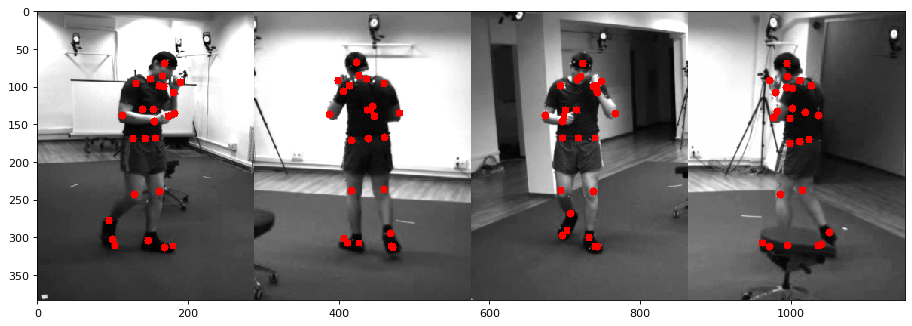

In [42]:
batch_image_cam0 = make_output(batch, 0, keypoints_3d_pred)
batch_image_cam1 = make_output(batch, 1, keypoints_3d_pred)
batch_image_cam2 = make_output(batch, 2, keypoints_3d_pred)
batch_image_cam3 = make_output(batch, 3, keypoints_3d_pred)

concated = cv2.hconcat([batch_image_cam0, batch_image_cam1,\
                        batch_image_cam2, batch_image_cam3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated[:,:,::-1])

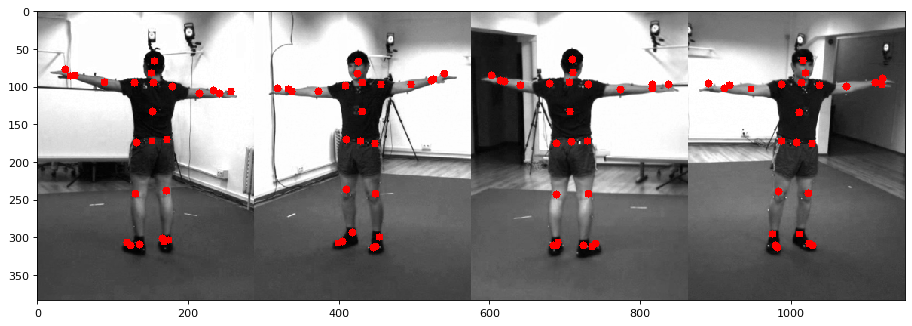

In [15]:
batch_image_cam0 = make_output(batch, 0, keypoints_3d_pred)
batch_image_cam1 = make_output(batch, 1, keypoints_3d_pred)
batch_image_cam2 = make_output(batch, 2, keypoints_3d_pred)
batch_image_cam3 = make_output(batch, 3, keypoints_3d_pred)

concated = cv2.hconcat([batch_image_cam0, batch_image_cam1,\
                        batch_image_cam2, batch_image_cam3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated[:,:,::-1])

In [16]:
import glob
import os

dataset_dir = '/datasets/human3.6m_LT/processed/S11/*'
action_dir_list = glob.glob(dataset_dir)

action_list = [os.path.basename(x) for x in action_dir_list]

#action_list = ['Walking-1']

print(action_list)

['Directions-1', 'Directions-2', 'Discussion-1', 'Discussion-2', 'Eating-1', 'Eating-2', 'Greeting-1', 'Greeting-2', 'MySegmentsMat', 'Phoning-1', 'Phoning-2', 'Posing-1', 'Posing-2', 'Purchases-1', 'Purchases-2', 'Sitting-1', 'Sitting-2', 'SittingDown-1', 'SittingDown-2', 'Smoking-1', 'Smoking-2', 'TakingPhoto-1', 'TakingPhoto-2', 'Waiting-1', 'Waiting-2', 'Walking-1', 'Walking-2', 'WalkingDog-1', 'WalkingDog-2', 'WalkingTogether-1', 'WalkingTogether-2']


In [17]:
# (384, 288)
# (384, 384)

# option_384x288= ?
# image_shape=(384, 384)


save_debug = False

batch_size = 1

number_of_camera = 4
camera_idx = range(number_of_camera)


subject_name = 'S11'
#action_name = 'TakingPhoto-1'

for action_name in action_list:

    try:
        HUMAN36M_dataset = human36m_custom.Human36MMultiViewDataset_CUSTOM(h36m_root='/datasets/human3.6m_LT_custom/processed/',
                         labels_path='/datasets/human3.6m_LT_custom/extra/human36m-multiview-labels-GTbboxes.npy',
                         pred_results_path=None,
                         image_shape=(384, 288),
                         train=False,
                         test=True,
                         retain_every_n_frames_in_test=1,
                         with_damaged_actions=False,
                         cuboid_side=2000.0,
                         scale_bbox=1.2,
                         norm_image=True,
                         kind="mpii",
                         undistort_images=True,
                         ignore_cameras=[],
                         crop=True,
                         target_subject = subject_name,
                         target_action = action_name,
                         option_384x288=True)
    except:
        print('action_name does not exist! continued.')
        continue


    HUMAN36M_dataloader = DataLoader(
        HUMAN36M_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=dataset_utils.make_collate_fn(False,
                                                 min_n_views=4,
                                                 max_n_views=4),
        num_workers=8,
        worker_init_fn=dataset_utils.worker_init_fn,
        pin_memory=True
    )
    print('action name is: {}'.format(action_name))
    print(HUMAN36M_dataset.__len__())

    savepath = os.path.join('/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results', subject_name,\
                               action_name)

    if not os.path.isdir(savepath):
        os.makedirs(savepath, exist_ok=True)
    print(savepath)

    if save_debug:
        fig_plot = figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

        x_range = 2000
        y_range = 2000
        z_range = 2000

    iterator = enumerate(HUMAN36M_dataloader)
    tmp_results = defaultdict(list)
    model.eval()

    image_count = 0
    iter_count= 0

    predicted_3d_holder = []

    with torch.no_grad():
        for iter_i, batch in iterator:

            if iter_count%100 == 0:
                print(iter_count)

            #images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, SMPL_pose, SMPL_shape = dataset_utils.prepare_SMPL_batch(batch, device, config)
            images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device, config)
            keypoints_3d_pred, heatmaps_pred, volumes_pred, confidences_pred, cuboids_pred, coord_volumes_pred, base_points_pred = model(images_batch, proj_matricies_batch, batch)
            iter_count += 1

            for idx in range(batch_size):
                predicted_3d_holder.append(keypoints_3d_pred.detach().cpu().numpy()[idx, :, :])

                #for joint in range(keypoints_3d_np.shape[0]):
                # 3,4 * 4,17 -> 3,17
                if save_debug:

                    batch_image_cam0 = make_output(batch, 0, keypoints_3d_pred)
                    batch_image_cam1 = make_output(batch, 1, keypoints_3d_pred)
                    batch_image_cam2 = make_output(batch, 2, keypoints_3d_pred)
                    batch_image_cam3 = make_output(batch, 3, keypoints_3d_pred)

                    concated_input = cv2.hconcat([batch_image_cam0, batch_image_cam1,\
                                            batch_image_cam2, batch_image_cam3])


                    #######################################################################################################
                    ax = fig_plot.add_subplot(1, 1, 1)
                    fig_plot = figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
                    ax = plt.axes(projection='3d')
                    ax.set_xlim3d(-x_range, x_range)
                    ax.set_ylim3d(-y_range, y_range)
                    ax.set_zlim3d(0,z_range)
                    ax.scatter3D(keypoints_3d_pred.detach().cpu().numpy()[idx, :, 0], keypoints_3d_pred.detach().cpu().numpy()[idx, :, 1], keypoints_3d_pred.detach().cpu().numpy()[idx, :, 2])
                    x = fig2data(fig_plot)

                    fig_1 = x[70:-70,70:-70,:3]
                    fig_1 = cv2.resize(fig_1, dsize=(384, 384))

                if save_debug:
                    full_img = cv2.hconcat([concated_input, fig_1[:,:,::-1]])
                    cv2.imwrite(os.path.join(savepath, '%06d.png'%image_count), full_img)
                    image_count += 1
                    fig_plot.clear()
                    plt.close('all')

    np.save(os.path.join(savepath,'predicted_3d_extended.npy'), predicted_3d_holder)
    # (datanum, camera, x-y-1, 17)

action name is: Directions-1
1552
/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results/S11/Directions-1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
action_name does not exist! continued.
action name is: Discussion-1
2684
/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results/S11/Discussion-1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
action name is: Discussion-2
2198
/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results/S11/Discussion-2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
action name is: Eating-1
2275
/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results/S11/Eating-1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
170

In [16]:
save_debug = False

batch_size = 1

number_of_camera = 4
camera_idx = range(number_of_camera)

subject_name = 'S11'
#action_name = 'TakingPhoto-1'

for action_name in action_list:

    try:
        HUMAN36M_dataset = human36m_custom.Human36MMultiViewDataset_CUSTOM(h36m_root='/datasets/human3.6m_LT_custom/processed/',
                         labels_path='/datasets/human3.6m_LT_custom/extra/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy',
                         pred_results_path=None,
                         image_shape=(384, 288),
                         train=False,
                         test=True,
                         retain_every_n_frames_in_test=1,
                         with_damaged_actions=False,
                         cuboid_side=2000.0,
                         scale_bbox=1.2,
                         norm_image=True,
                         kind="mpii",
                         undistort_images=False,
                         ignore_cameras=[],
                         crop=True,
                         target_subject = subject_name,
                         target_action = action_name,
                         is_extended = True)
    except:
        print('action_name does not exist! continued.')
        continue


    HUMAN36M_dataloader = DataLoader(
        HUMAN36M_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                                 min_n_views=4,
                                                 max_n_views=4),
        num_workers=8,
        worker_init_fn=dataset_utils.worker_init_fn,
        pin_memory=True
    )
    print('action name is: {}'.format(action_name))
    print(HUMAN36M_dataset.__len__())

    savepath = os.path.join('/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results', subject_name,\
                               action_name)


    iterator = enumerate(HUMAN36M_dataloader)
    model.eval()

    image_count = 0
    iter_count= 0

    predicted_3d_holder = []
    predicted_GT_holder = []

    with torch.no_grad():
        for iter_i, batch in iterator:

            if iter_count%100 == 0:
                print(iter_count)

            #images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, SMPL_pose, SMPL_shape = dataset_utils.prepare_SMPL_batch(batch, device, config)
            images_batch, keypoints_3d_batch_gt, keypoints_3d_validity_batch_gt, proj_matricies_batch, keypoints_3d_batch_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)
            #keypoints_3d_pred, heatmaps_pred, volumes_pred, confidences_pred, cuboids_pred, coord_volumes_pred, base_points_pred = model(images_batch, proj_matricies_batch, batch)
            iter_count += 1

            for idx in range(batch_size):
                #predicted_3d_holder.append(keypoints_3d_pred.detach().cpu().numpy()[idx, :, :])
                predicted_GT_holder.append(keypoints_3d_batch_extended_gt.detach().cpu().numpy()[idx, :, :])


    np.save(os.path.join(savepath,'predicted_GT_extended.npy'), predicted_GT_holder)
    # (datanum, camera, x-y-1, 17)

action name is: Directions-1
1552
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
action_name does not exist! continued.
action name is: Discussion-1
2684
0
100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

200


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

300


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe292d52e60>
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
action name is: Discussion-2
2198
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
action name is: Eating-1
2275
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
action name is: Eating-2
2203
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
action name is: Greeting-1
1695
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
action name is: Greeting-2
1808
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
action_name does not exist! continued.
action name is: Phoning-1
3390
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
action name is: Phoning-2
3492
0
100
200
300


In [15]:
predicted_GT_holder[0].shape

(25, 3)

In [ ]:
# MPJPE CALCULATE

In [8]:
action_list = ['Sitting-2']

In [9]:
batch_size = 1
number_of_camera = 4
camera_idx = range(number_of_camera)

subject_name = 'S11'

for action_name in action_list:
    savepath = os.path.join('/workspace/learnable_triangulation_unification/learnable_triangulation/H36M_EXTENDED_MARKER_results', subject_name,\
                               action_name)
    
    GT_npy = np.load(os.path.join(savepath, 'predicted_GT_extended.npy'))
    predicted_npy = np.load(os.path.join(savepath, 'predicted_3d_extended.npy'))
    
    assert GT_npy.shape == predicted_npy.shape

    GT_npy -= GT_npy[:,6:7,:]
    predicted_npy -= predicted_npy[:,6:7,:]
    
    MPJPE = np.linalg.norm(GT_npy - predicted_npy, axis=2)
    print(np.mean(MPJPE))


24.614634
